# Control Discrete CartRacing-v3 Environment

**Students :** Adrien Fu, Raphael Faure

**Date :** March 28, 2025

<u>CAUTION</u> : Install only the `gymnasium` library, if you also have the `gym` library, it can lead to some packaging problems that prevent using the CarRacing-v3 environment

In [ ]:
#!pip install gymnasium
#!pip install "gymnasium[box2d]"

In [ ]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2

## CarRacing-v3 environment

Let's first take a look at the discrete `CarRacing-v3` environment. More information [here](https://gymnasium.farama.org/environments/box2d/car_racing/).

In [ ]:
env = gym.make("CarRacing-v3",domain_randomize=False, continuous=False, render_mode="human")
# render_mode = 'human', 'rgb_array', 'state_pixels'
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space) # 0: do nothing, 1: steer right, 2: steer left, 3: gas, 4: brake

Observation space:  Box(0, 255, (96, 96, 3), uint8)
Action space:  Discrete(5)


- The game observation consists of frames of game state, where each frame is a 96 × 96 RGB image of the car and race track.
- There are $5$ actions: $0 =$ do nothing, $1 =$ full steer left, $2 =$ full steer right, $3 =$ full gas, $4 =$ full brake.
- The agent will receive reward $-0.1$ every frame and $+1000/N$ for every track tile visited, where $N$ is the total number of tiles visited in the track. 
- The goal is to finish the race successfully in the least number of frames possible (fast).

---

## Control CarRacing-v3 environment using Deep Q-Network (DQN)

### Test of the environment

In [ ]:
'''obs, info = env.reset()
env.render()

while True:
    action = env.action_space.sample()
    obs, r, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        break
env.close()'''

'obs, info = env.reset()\nenv.render()\n\nwhile True:\n    action = env.action_space.sample()\n    obs, r, terminated, truncated, info = env.step(action)\n    if terminated or truncated:\n        break\nenv.close()'

At the beginning, the game screen gradually zooms in for the first 50 steps, which may hinder our agent from learning to control the car. Thus, we will not use the first 50 steps of the game.

The second thing we have to know is that we are given only one current game frame for each step. This observation setting cannot satisfy the Markov property. We cannot guess if the car is moving forward or backward from only one frame, which means we cannot predict the next frame for given the current frame. Thus, we need to stack previous frames, to have information on how the car is moving.
<br>

More precisely, we will do the following steps to define our state space:

1. The raw frames are preprocessed by first converting their RGB representation to gray-scale, and reshaped to a smaller size around the car (size $60 \times 60$)
2. We use a simple frame-skipping technique: the agent sees and selects actions on every $k=4$ frames instead of every frame, and its last action is repeated on skipped frames.
3. The state is obtained by stacking the last $k=4$ grayscale frames.

In [ ]:
# Function for preprocessing each game frame. 
def preprocess(img):
    img = img[24:84, 17:77] # specific cropping, where the car is always centered at (71,47)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

Now, we change the intial environment to apply the setting (`reset` method below) and observations (`step` method below) described above.

In [ ]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames
    
    def reset(self):
        # Reset the original environment.
        s, info = self.env.reset()
        # Do nothing for the next `self.initial_no_op` steps
        for _ in range(self.initial_no_op):
            s, _, _, _, info = self.env.step(0)
        s = preprocess(s)

        # The initial observation is simply k copies of the frame `s`
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))  # of size [4, 84, 84]
        return self.stacked_state, info
    
    def step(self, action):
        # We take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        # Convert a frame to 84 X 84 gray scale one
        s = preprocess(s)

        # Push the current frame `s` at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info


We can create our desired environment as follows:

In [ ]:
env = gym.make("CarRacing-v3", domain_randomize=False, continuous=False, render_mode="rgb_array")
env = ImageEnv(env)

The shape of an observation:  (4, 60, 60)


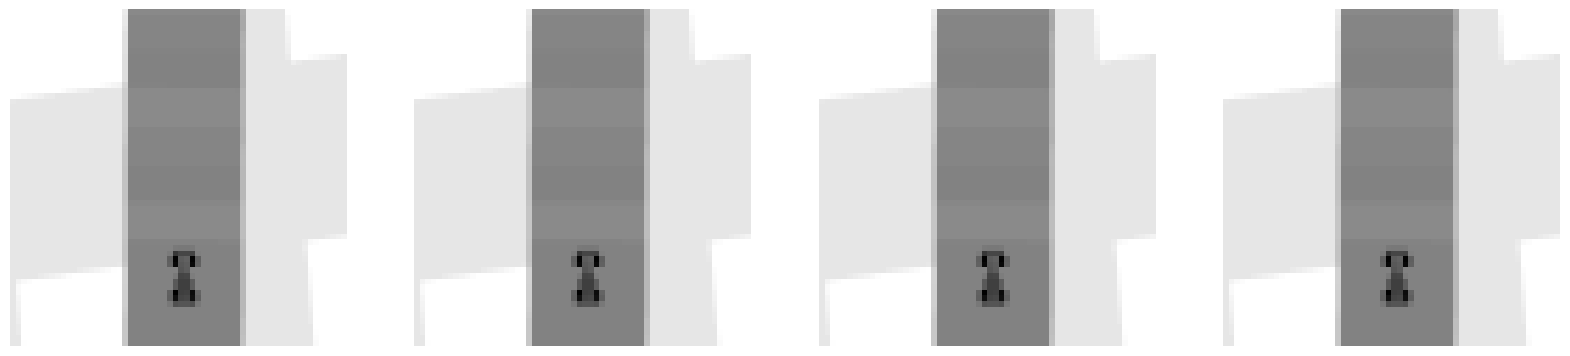

In [ ]:
s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

Let's do `gas` action for the next 4 steps. You can see our car was moving forward!
(The position of the car does not seem to change, but it is actually moving forward. See background)

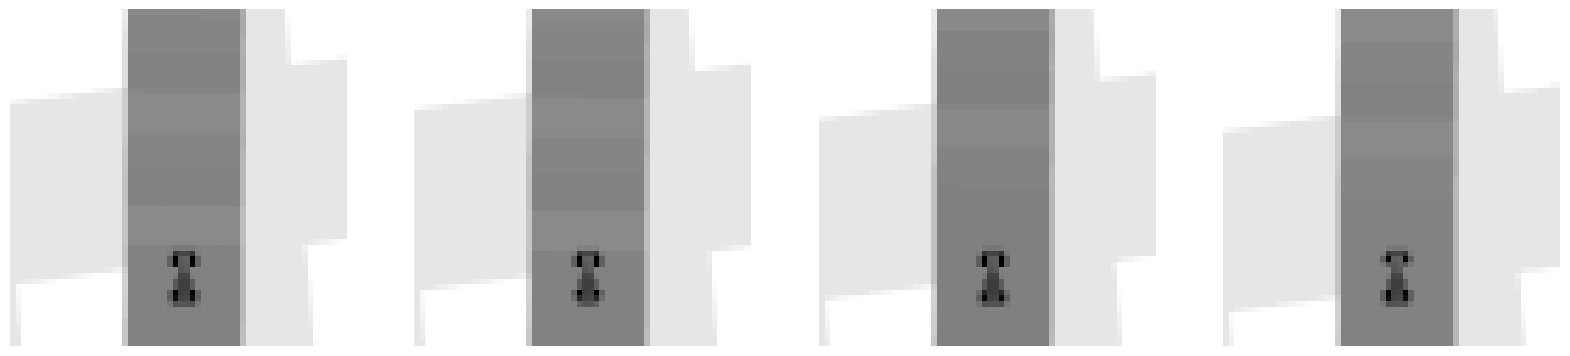

In [ ]:
for i in range(4):
    s, r, terminated, truncated, info = env.step(3)  # 3rd action is `gas` action

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

### Q-network

- The input to the neural network consists of an array of size 60 × 60 × 4. 
- The first hidden layer convolves 16 filters of size 8 x 8 with stride 4 with the input image and applies a ReLU.
- The second hidden layer convolves 32 filters of size 4 x 4 with stride 2, again followed by a ReLU.
- The final hidden layer is fully-connected and consists of 256 rectifier units. The output layer is a fully-connected linear layer with a single output for each valid action.

In [ ]:
class CNNActionValue(nn.Module):
    def __init__(self, state_dim, action_dim): #state_dim = number of frames = 4, action_dim = 5
        super(CNNActionValue, self).__init__()
        self.conv1 = nn.Conv2d(state_dim, 16, kernel_size=8, stride=4)  # [N, 4, 60, 60] -> [N, 16, 14, 14]
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)  # [N, 16, 14, 14] -> [N, 32, 6, 6]
        self.in_features = 32 * 6 * 6
        self.fc1 = nn.Linear(self.in_features, 256)
        self.fc2 = nn.Linear(256, action_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view((-1, self.in_features))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
network = CNNActionValue(4,5) 
s = 0
for x in network.parameters():
    if x.requires_grad:
        s+= np.prod(x.shape)
print(f"Number of trainable parameters : {s}") # 308,789

Number of trainable parameters : 308789


### Replay buffer

A replay buffer is a memory storage mechanism that stores past experiences collected by the agent while interacting with the environment. Instead of learning immediately from each experience, the agent stores these experiences and later samples from them to improve learning stability and efficiency.

In [ ]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (
            torch.FloatTensor(self.s[ind]),
            torch.FloatTensor(self.a[ind]),
            torch.FloatTensor(self.r[ind]),
            torch.FloatTensor(self.s_prime[ind]),
            torch.FloatTensor(self.terminated[ind]), 
        )

### DQN agent
DQN agent has four methods.
- `__init__`() as usual.
- `act()` takes as input one state of np.ndarray and output actions by following epsilon-greedy policy.
- `process()` method takes one transition as input and define what the agent do for each step.
- `learn()` method samples a mini-batch from replay buffer and train Q-network.

We will train our DQN agent until the total number of interactions with the environment reaches $600000$ and evaluate our agent every $1000$ steps. For the $\epsilon$-greedy policy, we use the initial epsilon of $1.0$ and linearly decrease it to $0.1$.

In [ ]:
class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        lr=0.0004,
        epsilon=1.0,
        epsilon_min=0.1,
        gamma=0.99,
        batch_size=32,
        warmup_steps=5000,
        buffer_size=int(1e5),
        target_update_interval=10000,
    ):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.network = CNNActionValue(state_dim[0], action_dim)
        self.target_network = CNNActionValue(state_dim[0], action_dim)
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = torch.optim.RMSprop(self.network.parameters(), lr)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)
        self.device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
        self.device = torch.device('cpu')
        self.network.to(self.device)
        self.target_network.to(self.device)
        
        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 6e5
    
    @torch.no_grad()
    def act(self, x, training=True):
        self.network.train(training)
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = np.random.randint(0, self.action_dim)
        else:
            x = torch.from_numpy(x).float().unsqueeze(0).to(self.device)
            q = self.network(x)
            a = torch.argmax(q).item()
        return a
    
    def learn(self):
        s, a, r, s_prime, terminated = map(lambda x: x.to(self.device), self.buffer.sample(self.batch_size))
        
        next_q = self.target_network(s_prime).detach()
        td_target = r + (1. - terminated) * self.gamma * next_q.max(dim=1, keepdim=True).values
        self.optimizer.zero_grad()
        loss = F.mse_loss(self.network(s).gather(1, a.long()), td_target)
        loss.backward()
        self.optimizer.step()
        
        result = {
            'total_steps': self.total_steps,
            'value_loss': loss.item()
        }
        return result
    
    def process(self, transition):
        result = {}
        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            result = self.learn()
            
        if self.total_steps % self.target_update_interval == 0:
            self.target_network.load_state_dict(self.network.state_dict())
        self.epsilon -= self.epsilon_decay
        return result

### Training DQN Agent

In [ ]:
env = gym.make("CarRacing-v3", domain_randomize=False, continuous=False, render_mode="rgb_array")
env = ImageEnv(env)

max_steps = int(6e5)
eval_interval = 1000
state_dim = (4, 60, 60)
action_dim = env.action_space.n

DQN_agent = DQN(state_dim, action_dim)

In [ ]:
def evaluate(env, agent, n_evals=5):
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

The cell below needs 11h to run

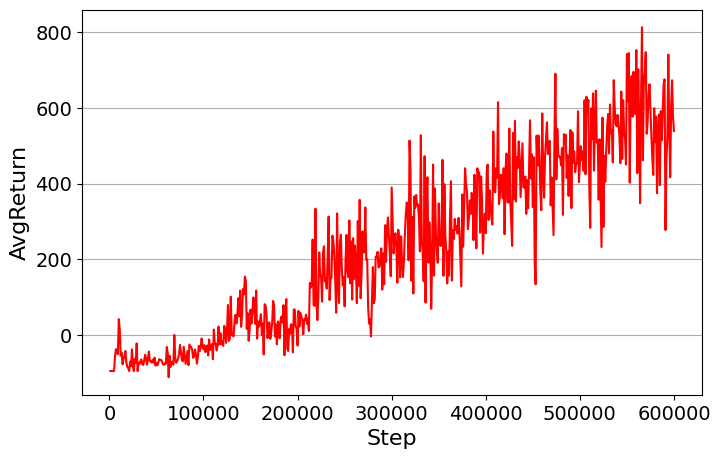

In [ ]:
history = {'Step': [], 'AvgReturn': []}

(s, _) = env.reset()
while True:
    a = DQN_agent.act(s)
    s_prime, r, terminated, truncated, info = env.step(a)
    result = DQN_agent.process((s, a, r, s_prime, terminated))  # You can track q-losses over training from `result` variable.
    
    s = s_prime
    if terminated or truncated:
        s, _ = env.reset()
        
    if DQN_agent.total_steps % eval_interval == 0:
        ret = evaluate(env, DQN_agent)
        history['Step'].append(DQN_agent.total_steps)
        history['AvgReturn'].append(ret)
        
        clear_output()
        plt.figure(figsize=(8, 5))
        plt.plot(history['Step'], history['AvgReturn'], 'r-')
        plt.xlabel('Step', fontsize=16)
        plt.ylabel('AvgReturn', fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid(axis='y')
        plt.show()
        
        torch.save(DQN_agent.network.state_dict(), 'dqn.pt')
    
    if DQN_agent.total_steps > max_steps:
        break

### Test of the DQN agent

In [ ]:
env = gym.make("CarRacing-v3", domain_randomize=False, continuous=False, render_mode="rgb_array")
env = ImageEnv(env)

DQN_agent_test = DQN(state_dim, action_dim)
DQN_agent_test.network.load_state_dict(torch.load('true_dqn.pt'))
DQN_agent_test.network.eval()

CNNActionValue(
  (conv1): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)

In [ ]:
x = evaluate(env, DQN_agent_test, n_evals=5)
print(f"Average return for the DQN agent : {x}")

Average return for the DQN agent : 633.7461


In [ ]:
# Simulation of the agent_test
env = gym.make("CarRacing-v3",domain_randomize=False, continuous=False, render_mode="human")
env = ImageEnv(env)

(s, _), done, ret = env.reset(), False, 0

done = False
env.render()

while not done:
    a = DQN_agent_test.act(s, training=False)
    s, r, terminated, truncated, info = env.step(a)
    done = terminated or truncated

env.close()

---

## Control CarRacing-v3 environment using Proximal Policy Optimizer (PPO)

Here, we use the PPO algorithm implemented in `stable_baselines3` library.

In [ ]:
from stable_baselines3 import PPO

env = gym.make("CarRacing-v3",domain_randomize=False, continuous=False, render_mode="rgb_array")
PPO_agent = PPO("CnnPolicy", env, verbose=1, learning_rate=1e-4, batch_size=32)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### Training PPO agent

We use the `learn` attribute to train our agent. However, we didn't find a way to retrieve automatically the rewards during the training, so we will save the printings of the function in `output_PPO.txt`, then retrieve the data inside to plot the graph of rewards by number of steps.

The cell below needs 3h to run.

In [ ]:
from contextlib import redirect_stdout

with open("output_PPO.txt", "w") as f: # to write the output of the PPO_agent in a txt file
    with redirect_stdout(f):
        PPO_agent.learn(total_timesteps=1e3)
        PPO_agent.save("ppo_data")

In [ ]:
import re

# Read the text file
with open("output_PPO.txt", "r") as file:
    text = file.read()

timesteps = [int(x) for x in re.findall(r'total_timesteps\s*\|\s*(\d+)', text)]
ep_rew_mean = [float(x) for x in re.findall(r'ep_rew_mean\s*\|\s*([-+]?\d*\.?\d+)', text)]

assert len(timesteps) == len(ep_rew_mean)

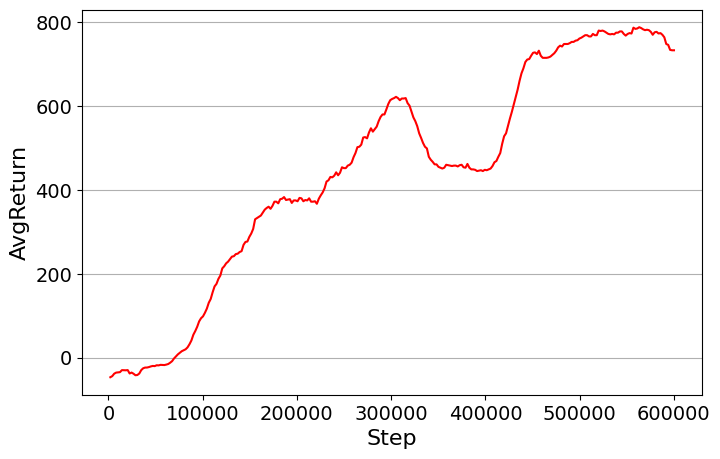

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(timesteps, ep_rew_mean, 'r-')
plt.xlabel('Step', fontsize=16)
plt.ylabel('AvgReturn', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.show()

### Test of the PPO agent

In [ ]:
env = gym.make("CarRacing-v3",domain_randomize=False, continuous=False, render_mode="rgb_array")

PPO_agent_test = PPO("CnnPolicy", env, verbose=1, learning_rate=1e-4, batch_size=32)
PPO_agent_test = PPO.load("ppo_data")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
n_evals = 5

score = 0
for _ in range(n_evals):
    (s, _), done, ret = env.reset(), False, 0
    while not done:
        action, _ = PPO_agent_test.predict(obs)
        obs, r, terminated, truncated, info = env.step(np.array(action))
        ret += r
        done = terminated or truncated
    score += ret
print(f"Average return for the PPO agent : {np.round(score / n_evals, 4)}")

Average return for the PPO agent : 774.1641


In [ ]:
# Simulation of PPO agent
env = gym.make("CarRacing-v3",domain_randomize=False, continuous=False, render_mode="human")

obs, _ = env.reset()
env.render()

while True:
    action, _ = PPO_agent_test.predict(obs)
    obs, r, terminated, truncated, info = env.step(np.array(action))
    if terminated or truncated:
        break

env.close()